In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.manifold import TSNE
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
local_dir = 'C:\\Users\\ASUS\\Documents\\PGM\\Project'
train_images_path = os.path.join(local_dir, 'k49-train-imgs.npz')
train_labels_path = os.path.join(local_dir, 'k49-train-labels.npz')

# Dataset Preparation
train_images = np.load(train_images_path)['arr_0']
train_labels = np.load(train_labels_path)['arr_0']

# Threshold to convert images to binary
threshold = 128

# Convert images to binary and count foreground pixels
def count_foreground_pixels(image, threshold):
    binary_image = image > threshold
    pixels = np.sum(binary_image)
    return pixels

# Median number of foreground pixels for each class
median_pixel_counts = []
class_labels = np.unique(train_labels)

for label in class_labels:
    class_indices = np.where(train_labels == label)
    pixel_counts = [count_foreground_pixels(train_images[i], threshold) for i in class_indices[0]]
    median_pixel_count = np.median(pixel_counts)
    median_pixel_counts.append(median_pixel_count)

# Thick/thin labels based on the median
style_labels = []

for i in range(len(train_labels)):
    label = train_labels[i]
    pixel_count = count_foreground_pixels(train_images[i], threshold)
    if pixel_count > median_pixel_counts[label]:
        style_labels.append(1)  # Thick
    else:
        style_labels.append(0)  # Thin

style_labels = np.array(style_labels)


In [3]:
print(len(style_labels))
for i in range (len(style_labels)):
    print(style_labels[i])


232365
0
1
0
1
1
0
1
0
1
1
1
0
0
0
1
0
1
0
0
0
0
1
0
0
0
1
0
1
0
0
0
1
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
1
0
1
0
0
1
0
0
0
0
1
1
0
1
1
0
1
0
0
1
1
1
0
0
1
1
1
0
0
1
1
0
1
1
1
1
0
0
1
1
0
0
1
1
1
1
1
0
1
0
1
0
0
0
0
1
1
0
1
1
1
1
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
1
1
0
1
0
1
0
1
1
0
1
0
1
0
1
0
1
1
1
0
0
1
1
1
0
1
0
0
1
0
1
1
1
0
0
1
0
0
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
1
0
1
0
1
1
0
0
0
0
0
1
1
0
1
0
0
0
1
1
1
0
1
1
0
1
0
1
0
0
1
0
0
1
0
0
1
0
1
1
1
0
1
0
0
0
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
1
0
1
1
1
0
0
1
1
1
0
0
1
1
0
1
0
1
0
1
0
0
0
1
0
1
1
0
0
1
0
1
0
0
0
1
1
1
0
0
0
0
0
0
1
1
1
0
1
1
0
1
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
1
1
0
1
1
1
1
0
1
0
0
1
0
1
0
1
1
0
1
1
1
1
0
0
0
0
0
0
1
0
1
1
1
1
1
0
1
0
1
0
0
0
0
1
0
1
1
1
1
1
1
0
0
1
0
1
0
1
0
0
0
0
0
1
1
0
0
0
1
1
1
0
1
0
0
1
1
0
1
0
0
0
0
0
0
1
1
0
1
1
1
0
1
0
1
0
0
0
1
1
0
1
1
0
0
0
1
0
0
0
1
0
0
0
1
1
0
1
1
1
1
0
0
1
0
1
1
0
1
1
1
0
0
1
1
0
1
1
0

In [4]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + num_classes + 1, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim + num_classes + 1, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x, labels, style):
        combined_input = torch.cat((x, labels, style), dim=1)
        mu, logvar = self.encode(combined_input)
        z = self.reparameterize(mu, logvar)
        combined_z = torch.cat((z, labels, style), dim=1)
        return self.decode(combined_z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramaters
input_dim = 784  # 28x28 images
hidden_dim = 144
latent_dim = 20
num_classes = 49

X_train = torch.tensor(train_images.reshape(-1, input_dim)).float() / 255.0
y_train = torch.tensor(train_labels).long()
style_labels = torch.tensor(style_labels).float().view(-1, 1)

style_labels = style_labels.repeat(X_train.size(0) // style_labels.size(0), 1)
print(f"X_train size: {X_train.size()}")
print(f"y_train size: {y_train.size()}")
print(f"style_labels size: {style_labels.size()}")
assert X_train.size(0) == y_train.size(0) == style_labels.size(0), "Size mismatch between tensors"

# One-hot encoding for labels
def to_one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]

y_train_one_hot = to_one_hot(y_train, num_classes)
train_dataset = TensorDataset(X_train, y_train_one_hot, style_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionalVAE(input_dim, hidden_dim, latent_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, optimizer, num_epochs, train_loader):
    model.train()
    total_loss = []


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x, y, s in train_loader:
            x, y, s = x.to(device), y.to(device), s.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x, y, s)
            loss = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    
        avg_epoch_loss = train_loss / len(train_loader.dataset)
        total_loss.append(avg_epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')
    
    return total_loss


X_train size: torch.Size([232365, 784])
y_train size: torch.Size([232365])
style_labels size: torch.Size([232365, 1])


Epoch 1, Loss: 239.9821734948922
Epoch 2, Loss: 201.8845261966626
Epoch 3, Loss: 196.55154499151388
Epoch 4, Loss: 194.02838526536914
Epoch 5, Loss: 192.41044717413203
Epoch 6, Loss: 191.285045323696
Epoch 7, Loss: 190.40887844991985
Epoch 8, Loss: 189.74510288988364
Epoch 9, Loss: 189.1311191696657
Epoch 10, Loss: 188.67672886844244
Epoch 11, Loss: 188.30116161828843
Epoch 12, Loss: 187.9683556850214
Epoch 13, Loss: 187.6728566351699
Epoch 14, Loss: 187.39321207004605
Epoch 15, Loss: 187.15359915384337
Epoch 16, Loss: 186.9761302597745
Epoch 17, Loss: 186.7917422271736
Epoch 18, Loss: 186.6317258811568
Epoch 19, Loss: 186.45902849504014
Epoch 20, Loss: 186.30582968706292
Epoch 21, Loss: 186.18288615247698
Epoch 22, Loss: 186.05755565143335
Epoch 23, Loss: 185.95662082183472
Epoch 24, Loss: 185.85253496065593
Epoch 25, Loss: 185.73617989545005
Epoch 26, Loss: 185.65702475261173
Epoch 27, Loss: 185.56985451397856
Epoch 28, Loss: 185.4816944659063
Epoch 29, Loss: 185.42065302450482
Epoch

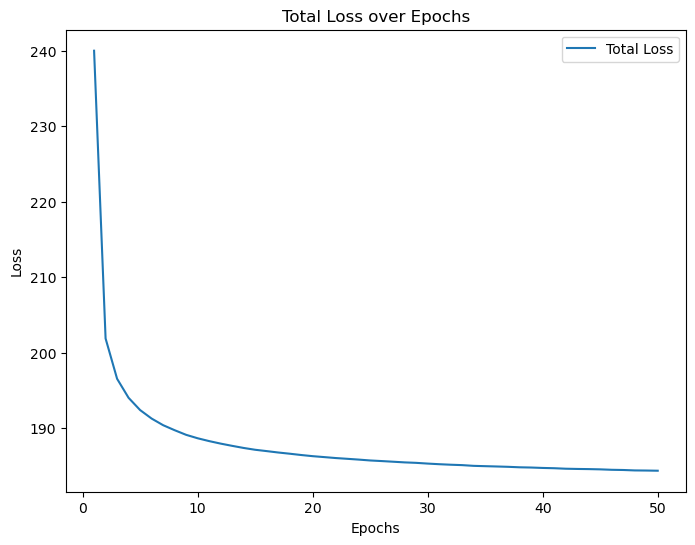

In [5]:
def plot_total_loss(total_loss):
    epochs = range(1, len(total_loss) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, total_loss, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Total Loss over Epochs')
    plt.legend()
    plt.show()

num_epochs = 50
total_loss = train(model, optimizer, num_epochs, train_loader)
plot_total_loss(total_loss)


In [6]:
num_images = 10

def show_original_images(images, labels, style, num_images = num_images):

    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
    
    for i in range(num_images):
        ax = axs[i]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {labels[i]}\nStyle: {'Thick' if style_labels[i] == 1 else 'Thin'}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_images(images, labels):
    pixels = images.reshape(-1, 28, 28)
    fig, axs = plt.subplots(ncols=len(images), nrows=1, figsize=(15,5))
    for i in range(len(images)):
        axs[i].imshow(pixels[i], cmap='gray')
        axs[i].set_title(f"Label: {labels[i]}\nStyle: {'Thick' if style_labels[i] == 1 else 'Thin'}")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel(f"Index: {i}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()




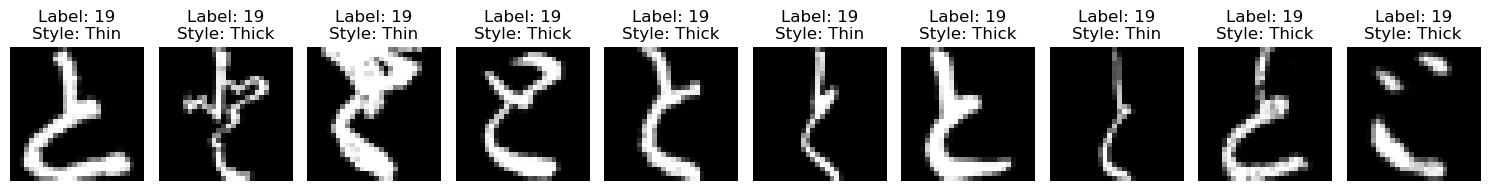

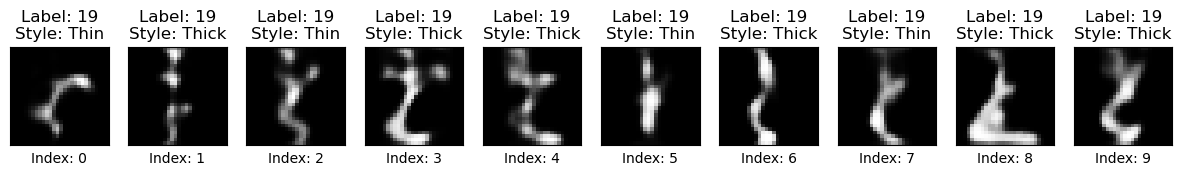

In [7]:
label = int(input("Enter the Label:"))
style = int(input("Enter the Style:"))

# Images 
num_images = 10
indices = np.where(train_labels == label)[0]
subset_indices = np.random.choice(indices, num_images, replace=False)
subset_images = train_images[indices]
subset_labels = train_labels[indices]
subset_styles = style

show_original_images(subset_images, subset_labels, subset_styles, num_images)

# Reconstruction
num_samples = 10
random_labels = [label] * num_samples
style_labels_sample = [style] * num_samples  
one_hot_labels = to_one_hot(torch.tensor(random_labels), 49).to(device)
style_labels_sample = torch.tensor(style_labels_sample).float().view(-1, 1).to(device)
labels = torch.cat((one_hot_labels, style_labels_sample), dim=1)

model.eval()
with torch.no_grad():
    z = torch.randn(num_samples, 20).to(device)
    combined_z = torch.cat((z, labels), dim=1)
    samples = model.decode(combined_z).cpu().detach().numpy()

show_images(samples, random_labels)